# Multi-class classification:

In this notebook we are using sklearn and pytorch to create a multi_class dataset and then use a model to classify them. The notebook is organized so:




*   Data preparation.

*   Multi class model building.

*   Choosing an optimizer and loss function.

*   Training the model.

*   Making predictions and evaluating the model.

*   Plot the boundary classification.




# 1-Getting and preparing the data:

To do so, we can leverage Scikit-Learn's [make_blobs()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) method.

This method will create however many classes (using the centers parameter) we want.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


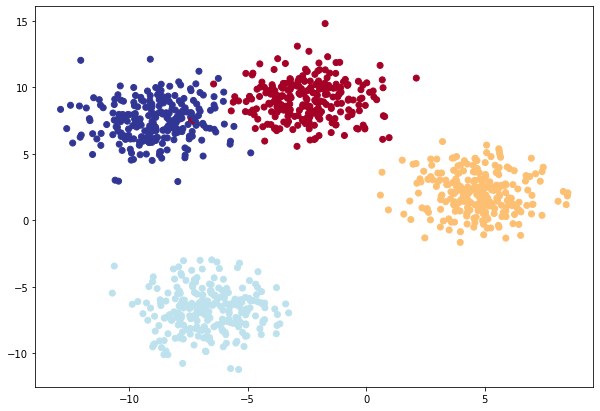

In [1]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

# 2- Building model:
We do so by subclassing nn.Module, and the model takes in 3 hyperparameters: 


*   input_features- the number of X features coming into the model.

*    output_features- the ideal numbers of classes we have.
*   hidden_units- the number of hidden neurons we'd like each hidden layer to use.


Let's put things together:


Before let's set agnostic device 

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

# 3. Defining a loss function and optimizer:

Since we're working on a multi-class classification problem, we'll use the nn.CrossEntropyLoss() method as our loss function.


And we'll stick with using SGD with a learning rate of 0.1 for optimizing our model_4 parameters.

In [4]:
# create loss and optimzer 

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)


# Getting prediction probabilities for a multi-class model:

Alright, we've got a loss function and optimizer ready, and we're ready to train our model but before we do let's do a single forward pass with our model to see if it works.

In [5]:
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.0717,  0.6718,  0.2652,  2.0835],
        [ 0.3570,  0.4354,  0.7421,  0.6172],
        [ 0.6439, -1.5400, -0.9172, -2.7924],
        [ 0.5318, -0.9539, -0.4974, -1.6670],
        [ 0.3919,  0.1915,  0.5359,  0.1983]], device='cuda:0',
       grad_fn=<SliceBackward0>)

It looks like we get one value per feature of each sample.

In [6]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

We need to turn these raw logits into prediction probabilities, to do so we are gonna use [the softmax activation function](https://machinelearningmastery.com/softmax-activation-function-with-python/).

The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

If this doesn't make sense, let's see in code.



In [7]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.0830,  0.7277,  0.3646,  2.0979],
        [ 0.5771, -0.2682,  0.4685, -1.0946],
        [ 0.5517, -1.2401, -0.7962, -2.0697],
        [ 0.1315,  0.3817,  0.0692,  1.5082],
        [ 0.2569,  0.7159,  0.8179,  1.3518]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.0852, 0.1624, 0.1130, 0.6393],
        [0.3977, 0.1708, 0.3568, 0.0747],
        [0.6670, 0.1112, 0.1733, 0.0485],
        [0.1392, 0.1787, 0.1308, 0.5513],
        [0.1365, 0.2161, 0.2393, 0.4081]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [8]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

Since there's one value for each class in y_pred_probs, the index of the highest value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value using torch.argmax().

In [9]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.0852, 0.1624, 0.1130, 0.6393], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')



You can see the output of torch.argmax() returns 3, so for the features (X) of the sample at index 0, the model is predicting that the most likely class value (y) is 3.

# 5. Training and testing loop:


In [10]:
# We need an evaluation metric first:

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [11]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.96659, Acc: 0.25% | Test Loss: 0.74930, Test Acc: 55.00%
Epoch: 10 | Loss: 0.17059, Acc: 99.25% | Test Loss: 0.14937, Test Acc: 99.50%
Epoch: 20 | Loss: 0.08683, Acc: 99.25% | Test Loss: 0.07749, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06166, Acc: 99.12% | Test Loss: 0.05339, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04999, Acc: 99.12% | Test Loss: 0.04182, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04338, Acc: 99.12% | Test Loss: 0.03511, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03918, Acc: 99.12% | Test Loss: 0.03076, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03629, Acc: 99.12% | Test Loss: 0.02772, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03420, Acc: 99.12% | Test Loss: 0.02548, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03262, Acc: 99.12% | Test Loss: 0.02375, Test Acc: 99.50%


# 6. Making and  evaluating predictions: 

It looks like our model has perofrmed very well, let's test it to make sure of that.

In [12]:
# Make predictions 

model_4.eval()

with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the 10 first preds 
y_logits[:10]

tensor([[  9.7106,  15.2560,  -9.4411,  -4.2863],
        [  0.2981, -15.0389,  -1.4457,   5.9249],
        [-13.3494, -18.4797,  13.2029,   4.9593],
        [  5.3582,  11.0702,  -5.0025,  -3.3911],
        [ 11.0755,   6.2525, -11.6117,  -0.5483],
        [ -0.3339, -18.9071,  -1.0473,   7.3250],
        [-12.3808, -14.2586,  12.4634,   3.4786],
        [  7.9948,   0.5961,  -8.6734,   1.1346],
        [-15.7576, -25.6141,  15.2950,   7.3316],
        [  8.9657,   2.6428,  -9.5795,   0.5014]], device='cuda:0')

Now our predictions still look like raw numbers, we need to turn them first into predictions probabilities then find the predicted class using softmax() and argmax()

Note: It's possible to skip the torch.softmax() function and go straight from predicted logits -> predicted labels by calling torch.argmax() directly on the logits.

For example, y_preds = torch.argmax(y_logits, dim=1), this saves a computation step (no torch.softmax()) but results in no prediction probabilities being available to use.

In [13]:
# Turn predictions into predectios probabilities 

y_probs = torch.softmax(y_logits, dim = 1)

#Turn those probabilities into predictions

y_preds = torch.argmax(y_probs, dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


Sounds good!

Let's visualize them with plot_decision_boundary(), remember because our data is on the GPU, we'll have to move it to the CPU for use with matplotlib (plot_decision_boundary() does this automatically for us).



In [14]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

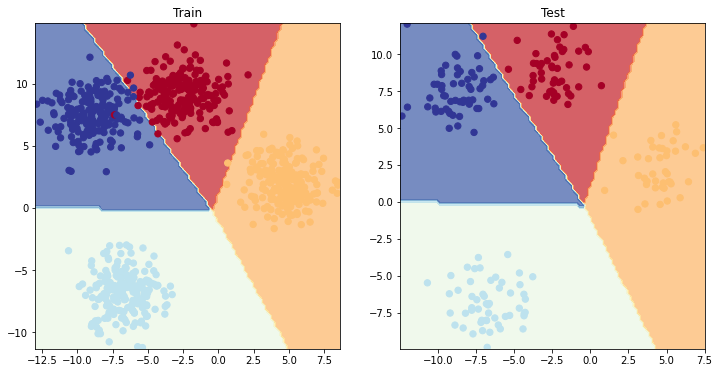

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)